In [1]:
import pickle
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
import random
import gym
from sklearn.preprocessing import StandardScaler
from collections import deque
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from river import drift

In [26]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)

In [27]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [4]:
# ---------------------------
# Custom Environment
# ---------------------------
class TabularClassificationEnv(gym.Env):
    def __init__(self, df):
        super(TabularClassificationEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_index = 0

        # Action space: two actions (0 and 1)
        self.action_space = gym.spaces.Discrete(2)
        # Observation space: features (assumes label is dropped)
        num_features = df.shape[1] - 1
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self):
        self.current_index = 0
        return self._get_observation()

    def step(self, action):
        if self.current_index >= len(self.df):
            return self._get_observation(), 0.0, True, {}

        # Retrieve the true label; assumes column name 'label'
        true_label = self.df.iloc[self.current_index]['label']

        # Modified reward structure:
        # If the sample is positive (label == 1), reward correctly.
        # Penalize misclassification more severely.
        if action == true_label:
            reward = 3.0 if true_label == 1 else 0.5
        else:
            reward = -3.0 if true_label == 1 else -1.0

        self.current_index += 1
        done = self.current_index >= len(self.df)
        if done:
            return self._get_observation(), reward, done, {}
        else:
            return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_index < len(self.df):
            row = self.df.iloc[self.current_index]
            if 'label' in self.df.columns:
                obs = row.drop('label').values.astype(np.float32)
            else:
                obs = row.values[:-1].astype(np.float32)
            return obs
        else:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

Initializing environment for agent

In [5]:
# ---------------------------
# Q-Network Definition
# ---------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes=(32, 32)):
        super(QNetwork, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# ---------------------------
# DQN Agent
# ---------------------------
class DQNAgent:
    def __init__(self, obs_dim, action_dim, hidden_sizes=(32, 32), lr=1e-3,
                 gamma=0.99, epsilon=0.1, device='cpu'):
        self.q_net = QNetwork(obs_dim, action_dim, hidden_sizes).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_dim = action_dim
        self.device = device

    def select_action(self, state):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def train_step(self, batch):
        # Unpack a batch of transitions
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute current Q-values for taken actions
        q_values = self.q_net(states).gather(1, actions)
        # Compute the next state's maximum Q-value
        next_q_values = self.q_net(next_states).max(1)[0].unsqueeze(1)
        # Compute TD target
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [7]:
# ---------------------------
# Simple Replay Buffer
# ---------------------------
class ReplayBuffer:
    def __init__(self):
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)

    def clear(self):
        self.buffer = []

    def sample_all(self):
        return self.buffer.copy()

    def __len__(self):
        return len(self.buffer)

In [8]:
# ---------------------------
# Training Function
# ---------------------------
def train_agent(agent, env, replay_buffer, num_iterations=1000, batch_size=32, verbose=True):
    state = env.reset()
    print("Training...")
    for i in range(num_iterations):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        if done:
            state = env.reset()

        # Train only if we have enough samples in the buffer
        if len(replay_buffer) >= batch_size:
            # Sample a mini-batch randomly from the replay buffer
            batch = random.sample(replay_buffer.buffer, batch_size)
            loss = agent.train_step(batch)
            if i % 100 == 0 and verbose:
                  print(f"Iteration {i}, Loss: {loss}")


In [9]:
feature_columns = scaler.feature_names_in_  # list of feature column names
obs_dim = len(feature_columns)
action_dim = 2  # binary classification

# Instantiate the RL agent and load its weights from the .pth file
dynamic_model = DQNAgent(obs_dim, action_dim, hidden_sizes=(128, 128), lr=0.001,
                          gamma=0.99, epsilon=0.1, device='cpu')
dynamic_model.q_net.load_state_dict(torch.load("dqn_model.pth", map_location=torch.device("cpu")))
dynamic_model.q_net.eval()

# Create a static copy of the RL agent (this one will not be updated)
static_model = copy.deepcopy(dynamic_model)

In [10]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

adwin_dynamic = drift.ADWIN()
adwin_static = drift.ADWIN()  

In [131]:
# for idx, message in enumerate(consumer):
#     # Decode and split the incoming message
#     row = message.value.decode().strip().split(',')
    
#     try:
#         row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
#     except ValueError:
#         print(f"Skipping invalid row: {row}")
#         continue
    
#     if 'Unnamed: 0' in row_df.columns:
#         row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
#     if 'label' in row_df.columns:
#         row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
#         # Ensure the 'label' column contains valid integers
#         row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
#         if row_df.empty:
#             print(f"Skipping row with invalid label: {row}")
#             continue
#         row_df['label'] = row_df['label'].astype(int)
    
#     for col in feature_columns:
#         row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
#     X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
#     X_new_static = static_scaler.transform(row_df[feature_columns])

#     y_new = int(row_df['label'].values[0])

#     dynamic_state = X_new_dynamic[0]
#     static_state  = X_new_static[0]

#     dynamic_pred = dynamic_model.select_action(dynamic_state)
#     static_pred  = static_model.select_action(static_state)
#     window_data.append((dynamic_state, y_new, dynamic_pred, static_pred))
    
#     if idx % 100 == 0:
#         print(f"Consumed {idx} messages")
    
#     if len(window_data) == window_size:
#         # Extract ground truth and predictions from the window
#         y_true = [entry[1] for entry in window_data]
#         dynamic_preds = [entry[2] for entry in window_data]
#         static_preds = [entry[3] for entry in window_data]
        
#         # Compute the weighted F1-score
#         current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
#         current_static_f1 = f1_score(y_true, static_preds, average='weighted')

#         current_dynamic_precision = precision_score(y_true, dynamic_preds, average='weighted')
#         current_dynamic_recall = recall_score(y_true, dynamic_preds, average='weighted')

#         cm = confusion_matrix(y_true, dynamic_preds)

#         if cm.shape == (2, 2):
#             TN, FP, FN, TP = cm.ravel()
#             false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
#         else:
#             false_positive_rate = None

#         try:
#             fpr, tpr, _ = roc_curve(y_true, dynamic_preds)
#             roc_auc = auc(fpr, tpr)
#         except Exception:
#             roc_auc = None

#         print(f"\nWindow complete:")
#         print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}, Precision: {current_dynamic_precision:.3f}, Recall: {current_dynamic_recall:.3f}, ", end='')
#         if false_positive_rate is not None:
#             print(f"FPR: {false_positive_rate:.3f}, ROC-AUC: {roc_auc:.3f}")
#         else:
#             print(f"ROC-AUC: {roc_auc:.3f}")
#         print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
#         dynamic_model_f1.append(current_dynamic_f1)
#         static_model_f1.append(current_static_f1)

#         # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
#         if current_dynamic_f1 < 0.75:
#             print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")
#             X_window = np.array([entry[0] for entry in window_data])
#             y_window = np.array([entry[1] for entry in window_data])

#             X_window_df = pd.DataFrame(X_window, columns=feature_columns)

#             new_scaler = StandardScaler().fit(X_window_df)
#             dynamic_scaler.mean_  = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
#             dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

#             X_window_scaled = dynamic_scaler.transform(X_window)

#             # Ensure the data used to fit the scaler matches the feature columns
#             X_window_df = pd.DataFrame(X_window_scaled, columns=feature_columns)
#             X_window_df['label'] = y_window
#             window_env = TabularClassificationEnv(X_window_df)

#             window_replay_buffer = ReplayBuffer()

#             dynamic_model.q_net.train()
#             train_agent(dynamic_model, window_env, window_replay_buffer, num_iterations=200, batch_size=32, verbose=True)
#             dynamic_model.q_net.eval()

#         # Clear the window for the next batch
#         window_data.clear()
#         window_count += 1
#         if window_count >= max_window_steps:
#             print(f"Reached max window steps ({max_window_steps}). Exiting...")
#             break

# print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window complete:
  Dynamic Model -> F1: 0.260, Precision: 0.381, Recall: 0.308, FPR: 0.877, ROC-AUC: 0.400
  Static Model  -> F1: 0.263
Dynamic model F1 (0.260) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.6920342445373535
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete:
  Dynamic Model -> F1: 0.685, Precision: 0.714, Recall: 0.675, FPR: 0.324, ROC-AUC: 0.674
  Static Model  -> F1: 0.251
Dynamic model F1 (0.685) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 3.5985255241394043
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', '

d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.318040132522583
Consumed 3100 messages
Consumed 3200 messages
Consumed 3300 messages
Consumed 3400 messages
Consumed 3500 messages
Consumed 3600 messages
Consumed 3700 messages
Consumed 3800 messages
Consumed 3900 messages
Consumed 4000 messages

Window complete:
  Dynamic Model -> F1: 0.706, Precision: 0.746, Recall: 0.698, FPR: 0.348, ROC-AUC: 0.719
  Static Model  -> F1: 0.267
Dynamic model F1 (0.706) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.4802775382995605
Consumed 4100 messages
Consumed 4200 messages
Consumed 4300 messages
Consumed 4400 messages
Consumed 4500 messages
Consumed 4600 messages
Consumed 4700 messages
Consumed 4800 messages
Consumed 4900 messages
Consumed 5000 messages

Window complete:
  Dynamic Model -> F1: 0.679, Precision: 0.769, Recall: 0.670, FPR: 0.425, ROC-AUC: 0.721
  Static Model  -> F1: 0.253
Dynamic model F1 (0.679) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 3.4130117893218994
Consumed 5100 messages
Consumed 5200 messages
Consumed 5300 messages
Consumed 5400 messages
Consumed 5500 messages
Consumed 5600 messages
Consumed 5700 messages
Consumed 5800 messages
Consumed 5900 messages
Consumed 6000 messages

Window complete:
  Dynamic Model -> F1: 0.694, Precision: 0.777, Recall: 0.687, FPR: 0.411, ROC-AUC: 0.735
  Static Model  -> F1: 0.272
Dynamic model F1 (0.694) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 3.3700051307678223
Consumed 6100 messages
Consumed 6200 messages
Consumed 6300 messages
Consumed 6400 messages
Consumed 6500 messages
Consumed 6600 messages
Consumed 6700 messages
Consumed 6800 messages
Consumed 6900 messages
Consumed 7000 messages

Window complete:
  Dynamic Model -> F1: 0.714, Precision: 0.784, Recall: 0.708, FPR: 0.382, ROC-AUC: 0.749
  Static Model  -> F1: 0.254
Dynamic model F1 (0.714) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 1.5533987283706665
Consumed 7100 messages
Consumed 7200 messages
Consumed 7300 messages
Consumed 7400 messages
Consumed 7500 messages
Consumed 7600 messages
Consumed 7700 messages
Consumed 7800 messages
Consumed 7900 messages
Consumed 8000 messages

Window complete:
  Dynamic Model -> F1: 0.676, Precision: 0.795, Recall: 0.666, FPR: 0.445, ROC-AUC: 0.735
  Static Model  -> F1: 0.244
Dynamic model F1 (0.676) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 1.956963300704956
Consumed 8100 messages
Consumed 8200 messages
Consumed 8300 messages
Consumed 8400 messages
Consumed 8500 messages
Consumed 8600 messages
Consumed 8700 messages
Consumed 8800 messages
Consumed 8900 messages
Consumed 9000 messages

Window complete:
  Dynamic Model -> F1: 0.683, Precision: 0.754, Recall: 0.674, FPR: 0.400, ROC-AUC: 0.713
  Static Model  -> F1: 0.253
Dynamic model F1 (0.683) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 1.325681447982788
Consumed 9100 messages
Consumed 9200 messages
Consumed 9300 messages
Consumed 9400 messages
Consumed 9500 messages
Consumed 9600 messages
Consumed 9700 messages
Consumed 9800 messages
Consumed 9900 messages
Consumed 10000 messages

Window complete:
  Dynamic Model -> F1: 0.730, Precision: 0.771, Recall: 0.724, FPR: 0.334, ROC-AUC: 0.748
  Static Model  -> F1: 0.259
Dynamic model F1 (0.730) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 1.4524613618850708
Consumed 10100 messages
Consumed 10200 messages
Consumed 10300 messages
Consumed 10400 messages
Consumed 10500 messages
Consumed 10600 messages
Consumed 10700 messages
Consumed 10800 messages
Consumed 10900 messages
Consumed 11000 messages

Window complete:
  Dynamic Model -> F1: 0.734, Precision: 0.749, Recall: 0.728, FPR: 0.271, ROC-AUC: 0.728
  Static Model  -> F1: 0.250
Dynamic model F1 (0.734) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.2758278846740723
Consumed 11100 messages
Consumed 11200 messages
Consumed 11300 messages
Consumed 11400 messages
Consumed 11500 messages
Consumed 11600 messages
Consumed 11700 messages
Consumed 11800 messages
Consumed 11900 messages
Consumed 12000 messages

Window complete:
  Dynamic Model -> F1: 0.711, Precision: 0.725, Recall: 0.705, FPR: 0.279, ROC-AUC: 0.698
  Static Model  -> F1: 0.256
Dynamic model F1 (0.711) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.313153028488159
Consumed 12100 messages
Consumed 12200 messages
Consumed 12300 messages
Consumed 12400 messages
Consumed 12500 messages
Consumed 12600 messages
Consumed 12700 messages
Consumed 12800 messages
Consumed 12900 messages
Consumed 13000 messages

Window complete:
  Dynamic Model -> F1: 0.704, Precision: 0.731, Recall: 0.695, FPR: 0.314, ROC-AUC: 0.700
  Static Model  -> F1: 0.256
Dynamic model F1 (0.704) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.6727561950683594
Consumed 13100 messages
Consumed 13200 messages
Consumed 13300 messages
Consumed 13400 messages
Consumed 13500 messages
Consumed 13600 messages
Consumed 13700 messages
Consumed 13800 messages
Consumed 13900 messages
Consumed 14000 messages

Window complete:
  Dynamic Model -> F1: 0.712, Precision: 0.742, Recall: 0.703, FPR: 0.313, ROC-AUC: 0.711
  Static Model  -> F1: 0.267
Dynamic model F1 (0.712) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.3294551372528076
Consumed 14100 messages
Consumed 14200 messages
Consumed 14300 messages
Consumed 14400 messages
Consumed 14500 messages
Consumed 14600 messages
Consumed 14700 messages
Consumed 14800 messages
Consumed 14900 messages
Consumed 15000 messages

Window complete:
  Dynamic Model -> F1: 0.695, Precision: 0.742, Recall: 0.685, FPR: 0.357, ROC-AUC: 0.708
  Static Model  -> F1: 0.271
Dynamic model F1 (0.695) is below threshold. Retraining dynamic model on this window...
Training...


d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100, Loss: 2.8692378997802734
Reached max window steps (15). Exiting...
Finished streaming from Kafka or timed out.


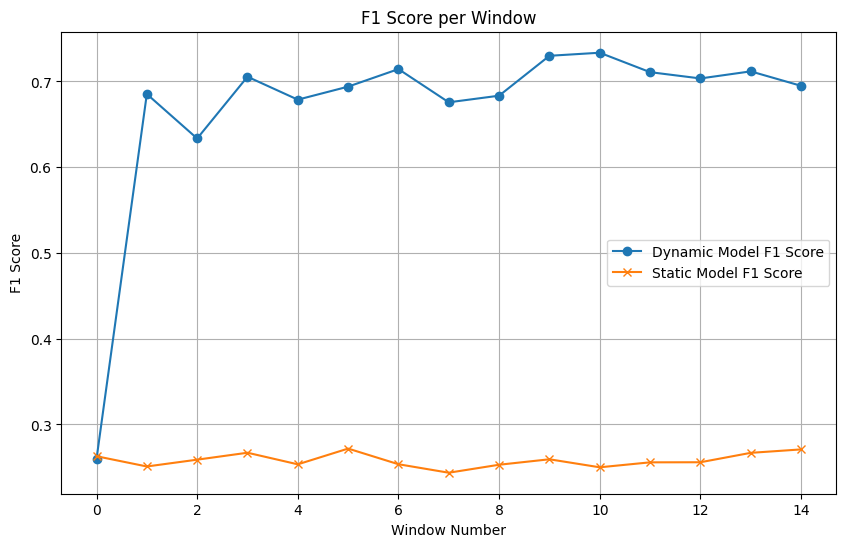

In [133]:
# import matplotlib.pyplot as plt

# # Plotting F1 scores per window
# plt.figure(figsize=(10, 6))
# plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
# plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
# plt.xlabel('Window Number')
# plt.ylabel('F1 Score')
# plt.title('F1 Score per Window')
# plt.legend()
# plt.grid(True)
# plt.show()


Dynamic RL model performs much better than the static RL model

In [11]:
for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])

    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_state = X_new_dynamic[0]
    static_state = X_new_static[0]
    dynamic_pred = dynamic_model.select_action(dynamic_state)
    static_pred = static_model.select_action(static_state)
    
    # Update ADWIN with prediction correctness (1=correct, 0=error)
    adwin_dynamic.update(1 if dynamic_pred == y_new else 0)
    adwin_static.update(1 if static_pred == y_new else 0)
    
    window_data.append((dynamic_state, y_new, dynamic_pred, static_pred))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]
        
        # Compute the weighted F1-score
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        current_dynamic_precision = precision_score(y_true, dynamic_preds, average='weighted')
        current_dynamic_recall = recall_score(y_true, dynamic_preds, average='weighted')

        cm = confusion_matrix(y_true, dynamic_preds)

        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        else:
            false_positive_rate = None

        try:
            fpr, tpr, _ = roc_curve(y_true, dynamic_preds)
            roc_auc = auc(fpr, tpr)
        except Exception:
            roc_auc = None

        print(f"\nWindow complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}, Precision: {current_dynamic_precision:.3f}, Recall: {current_dynamic_recall:.3f}, ", end='')
        if false_positive_rate is not None:
            print(f"FPR: {false_positive_rate:.3f}, ROC-AUC: {roc_auc:.3f}")
        else:
            print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Drift detection and retraining logic
        if adwin_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            print(f"Current F1: {current_dynamic_f1:.3f}")
            
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Prepare RL training environment
            X_window_scaled = dynamic_scaler.transform(X_window)
            X_window_df = pd.DataFrame(X_window_scaled, columns=feature_columns)
            X_window_df['label'] = y_window
            window_env = TabularClassificationEnv(X_window_df)
            window_replay_buffer = ReplayBuffer()

            # Retrain DQN agent
            dynamic_model.q_net.train()
            train_agent(dynamic_model, window_env, window_replay_buffer, 
                       num_iterations=200, batch_size=32, verbose=True)
            dynamic_model.q_net.eval()
            
            adwin_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model drift
        if adwin_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Clear window and increment counter
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window complete:
  Dynamic Model -> F1: 0.140, Precision: 0.728, Recall: 0.218, FPR: 0.945, ROC-AUC: 0.505
  Static Model  -> F1: 0.161
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete:
  Dynamic Model -> F1: 0.149, Precision: 0.728, Recall: 0.238, FPR: 0.946, ROC-AUC: 0.510
  Static Model  -> F1: 0.156
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Consumed 2400 messages
Consumed 2500 messages
Consumed 2600 messages
Consumed 2700 messages
Consumed 2800 messages
Consumed 2900 messages

Window complete:
  Dynamic Model -> F1: 0.156, 

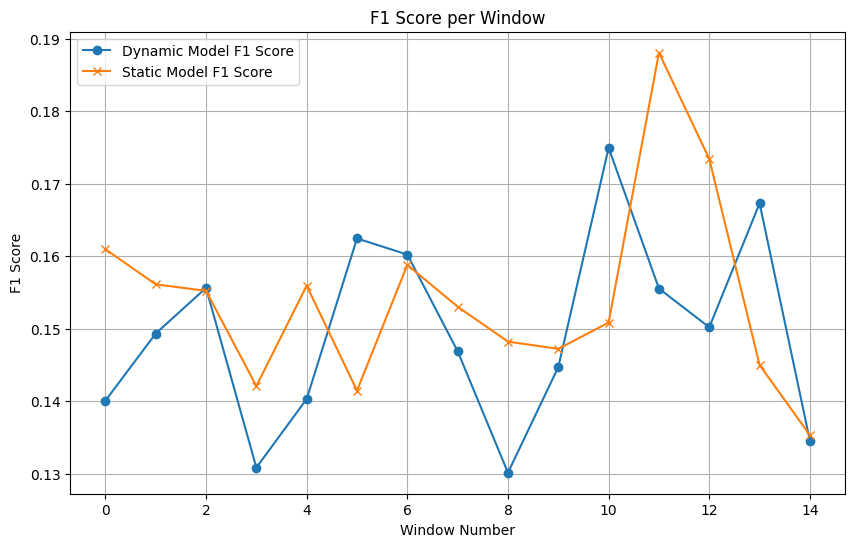

In [12]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()


<h2>Streaming using PageHinkley </h2>

In [21]:
feature_columns = scaler.feature_names_in_  # list of feature column names
obs_dim = len(feature_columns)
action_dim = 2  # binary classification

# Instantiate the RL agent and load its weights from the .pth file
dynamic_model = DQNAgent(obs_dim, action_dim, hidden_sizes=(128, 128), lr=0.001,
                          gamma=0.99, epsilon=0.1, device='cpu')
dynamic_model.q_net.load_state_dict(torch.load("dqn_model.pth", map_location=torch.device("cpu")))
dynamic_model.q_net.eval()

# Create a static copy of the RL agent (this one will not be updated)
static_model = copy.deepcopy(dynamic_model)

In [22]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

ph_dynamic = drift.PageHinkley()
ph_static = drift.PageHinkley()  

In [23]:
for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])

    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_state = X_new_dynamic[0]
    static_state = X_new_static[0]
    dynamic_pred = dynamic_model.select_action(dynamic_state)
    static_pred = static_model.select_action(static_state)
    
    # Update PH with prediction correctness (1=correct, 0=error)
    ph_dynamic.update(1 if dynamic_pred == y_new else 0)
    ph_static.update(1 if static_pred == y_new else 0)
    
    window_data.append((dynamic_state, y_new, dynamic_pred, static_pred))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]
        
        # Compute the weighted F1-score
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        current_dynamic_precision = precision_score(y_true, dynamic_preds, average='weighted')
        current_dynamic_recall = recall_score(y_true, dynamic_preds, average='weighted')

        cm = confusion_matrix(y_true, dynamic_preds)

        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        else:
            false_positive_rate = None

        try:
            fpr, tpr, _ = roc_curve(y_true, dynamic_preds)
            roc_auc = auc(fpr, tpr)
        except Exception:
            roc_auc = None

        print(f"\nWindow complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}, Precision: {current_dynamic_precision:.3f}, Recall: {current_dynamic_recall:.3f}, ", end='')
        if false_positive_rate is not None:
            print(f"FPR: {false_positive_rate:.3f}, ROC-AUC: {roc_auc:.3f}")
        else:
            print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Drift detection and retraining logic
        if ph_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            print(f"Current F1: {current_dynamic_f1:.3f}")
            
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Prepare RL training environment
            X_window_scaled = dynamic_scaler.transform(X_window)
            X_window_df = pd.DataFrame(X_window_scaled, columns=feature_columns)
            X_window_df['label'] = y_window
            window_env = TabularClassificationEnv(X_window_df)
            window_replay_buffer = ReplayBuffer()

            # Retrain DQN agent
            dynamic_model.q_net.train()
            train_agent(dynamic_model, window_env, window_replay_buffer, 
                       num_iterations=200, batch_size=32, verbose=True)
            dynamic_model.q_net.eval()
            
            ph_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model drift
        if ph_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Clear window and increment counter
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window complete:
  Dynamic Model -> F1: 0.156, Precision: 0.638, Recall: 0.256, FPR: 0.951, ROC-AUC: 0.499
  Static Model  -> F1: 0.163
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete:
  Dynamic Model -> F1: 0.162, Precision: 0.698, Recall: 0.241, FPR: 0.936, ROC-AUC: 0.505
  Static Model  -> F1: 0.144
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Consumed 2400 messages
Consumed 2500 messages
Consumed 2600 messages
Consumed 2700 messages
Consumed 2800 messages
Consumed 2900 messages

Window complete:
  Dynamic Model -> F1: 0.136, 

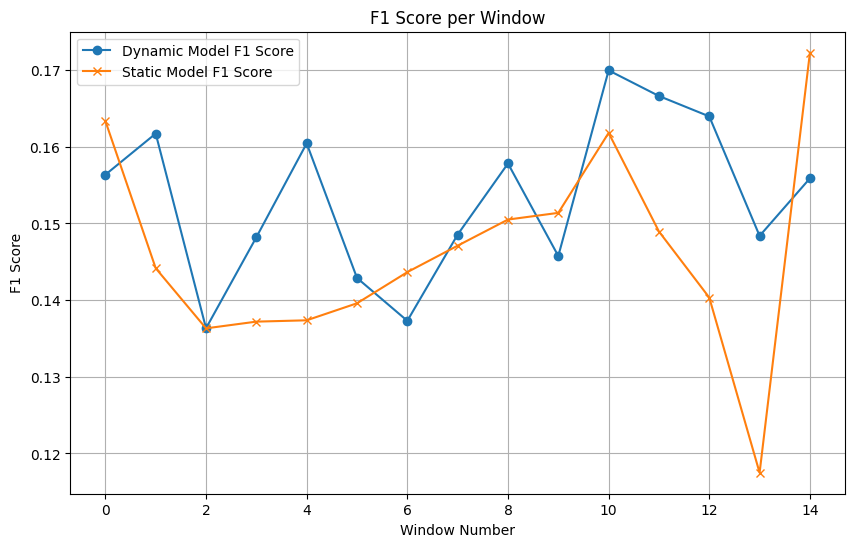

In [24]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()


<h2>Streaming using KSWIN </h2>

In [25]:
feature_columns = scaler.feature_names_in_  # list of feature column names
obs_dim = len(feature_columns)
action_dim = 2  # binary classification

# Instantiate the RL agent and load its weights from the .pth file
dynamic_model = DQNAgent(obs_dim, action_dim, hidden_sizes=(128, 128), lr=0.001,
                          gamma=0.99, epsilon=0.1, device='cpu')
dynamic_model.q_net.load_state_dict(torch.load("dqn_model.pth", map_location=torch.device("cpu")))
dynamic_model.q_net.eval()

# Create a static copy of the RL agent (this one will not be updated)
static_model = copy.deepcopy(dynamic_model)

In [28]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

kswin_dynamic = drift.KSWIN(seed=2021)
kswin_static = drift.KSWIN(seed=2021)

In [29]:
for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])

    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_state = X_new_dynamic[0]
    static_state = X_new_static[0]
    dynamic_pred = dynamic_model.select_action(dynamic_state)
    static_pred = static_model.select_action(static_state)
    
    # Update KSWIN with prediction correctness (1=correct, 0=error)
    kswin_dynamic.update(1 if dynamic_pred == y_new else 0)
    kswin_static.update(1 if static_pred == y_new else 0)
    
    window_data.append((dynamic_state, y_new, dynamic_pred, static_pred))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]
        
        # Compute the weighted F1-score
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        current_dynamic_precision = precision_score(y_true, dynamic_preds, average='weighted')
        current_dynamic_recall = recall_score(y_true, dynamic_preds, average='weighted')

        cm = confusion_matrix(y_true, dynamic_preds)

        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        else:
            false_positive_rate = None

        try:
            fpr, tpr, _ = roc_curve(y_true, dynamic_preds)
            roc_auc = auc(fpr, tpr)
        except Exception:
            roc_auc = None

        print(f"\nWindow complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}, Precision: {current_dynamic_precision:.3f}, Recall: {current_dynamic_recall:.3f}, ", end='')
        if false_positive_rate is not None:
            print(f"FPR: {false_positive_rate:.3f}, ROC-AUC: {roc_auc:.3f}")
        else:
            print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Drift detection and retraining logic
        if kswin_dynamic.drift_detected:
            print(f"\nDrift detected in dynamic model at window {window_count}! Retraining...")
            print(f"Current F1: {current_dynamic_f1:.3f}")
            
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler().fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Prepare RL training environment
            X_window_scaled = dynamic_scaler.transform(X_window)
            X_window_df = pd.DataFrame(X_window_scaled, columns=feature_columns)
            X_window_df['label'] = y_window
            window_env = TabularClassificationEnv(X_window_df)
            window_replay_buffer = ReplayBuffer()

            # Retrain DQN agent
            dynamic_model.q_net.train()
            train_agent(dynamic_model, window_env, window_replay_buffer, 
                       num_iterations=200, batch_size=32, verbose=True)
            dynamic_model.q_net.eval()
            
            kswin_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model drift
        if kswin_static.drift_detected:
            print(f"Static model drift detected (F1: {current_static_f1:.3f})")

        # Clear window and increment counter
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window complete:
  Dynamic Model -> F1: 0.139, Precision: 0.740, Recall: 0.218, FPR: 0.946, ROC-AUC: 0.508
  Static Model  -> F1: 0.134
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window complete:
  Dynamic Model -> F1: 0.159, Precision: 0.664, Recall: 0.238, FPR: 0.937, ROC-AUC: 0.497
  Static Model  -> F1: 0.136
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Consumed 2400 messages
Consumed 2500 messages
Consumed 2600 messages
Consumed 2700 messages
Consumed 2800 messages
Consumed 2900 messages

Window complete:
  Dynamic Model -> F1: 0.159, 

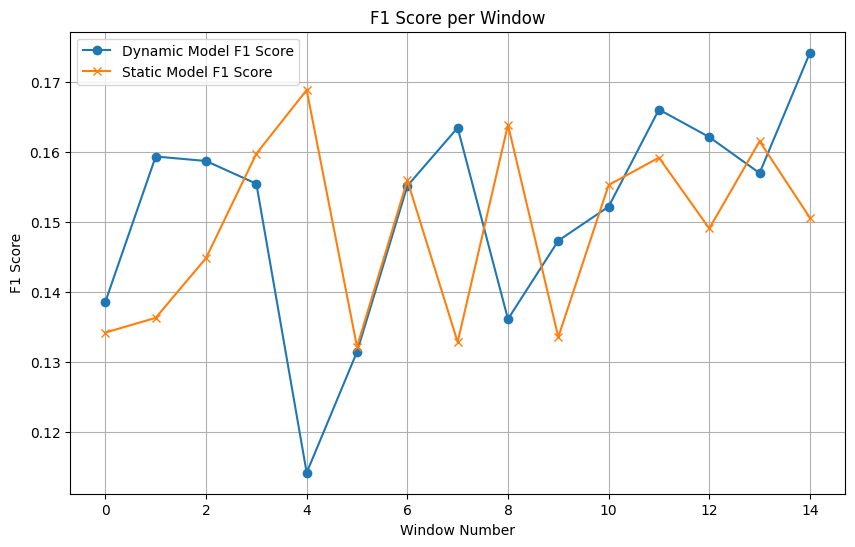

In [30]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()